# Regression Analysis
## Model
$$ Supply: P = aQ + sigma $$
$$ Demand: P = aQ + bIncome + Race + Age + Borough(InstrumentalVariable) + sigma $$
$$ P = aQ + bIncome + Race + Age + Borough + sigma $$

## Data preparation
### Independent variables: Income, Race, Age, Borough

In [1]:
import pandas as pd
import numpy as np

In [2]:
# import Income data in percentage
income = pd.read_csv('data/Demographics/Income/household_income_acs2018.csv')
income = income.sort_values(by='tract')
income = income.drop(columns=['city','tract','Households (HH) Count','Household Median Income','Household Mean Income'])
income['BoroCTLbl'] = income['BoroCTLbl'].astype(str)
income.head()

,county,BoroCTLbl,HH 0-10k,HH 10k-15k,HH 15k-25k,HH 25k-35k,HH 35k-50k,HH 50k-75k,HH 75k-100k,HH 100k-150k,HH 150k-200k,HH 200k-UP
0,Bronx,Bronx 1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1100,Manhattan,Manhattan 1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1388,Queens,Queens 1,4.9,0.3,2.5,2.2,2.6,8.2,10.5,20.9,15.8,32.2
339,Brooklyn,Brooklyn 1,3.2,2.2,9.4,2.7,5.0,14.0,19.3,9.8,13.9,20.5
340,Brooklyn,Brooklyn 2,11.6,5.3,6.1,23.8,10.8,21.1,6.4,8.6,1.1,5.3


In [3]:
# Race data in percentage
race = pd.read_csv('data/Demographics/Basic Count/tract_race_acs2018.csv')
race = race.assign(White = lambda x: x["White"]/x["Total"]*100,
                  Black = lambda x: x["Black"]/x["Total"]*100,
                  Native = lambda x: x["Native"]/x["Total"]*100,
                  Asian = lambda x: x["Asian"]/x["Total"]*100,
                  PacificIslander = lambda x: x["Pacific Islander"]/x["Total"]*100,
                  Other = lambda x: x["Other"]/x["Total"]*100,
                  TwoOrMore = lambda x: x["Two or More"]/x["Total"]*100)
race = race.fillna(0)
race = race.drop(columns=['city','county','Total','Two or More']).sort_values(by='tract')
race['BoroCTLbl'] = race['BoroCTLbl'].astype(str)
race.head()

,tract,BoroCTLbl,White,Black,Native,Asian,Pacific Islander,Other,PacificIslander,TwoOrMore
23,1.0,Bronx 1,25.042373,59.872881,0.353107,1.765537,0,12.005650,0.0,0.960452
907,1.0,Brooklyn 1,65.280572,15.157612,0.715404,8.920188,0,5.902079,0.0,4.024145
1225,1.0,Manhattan 1,0.000000,0.000000,0.000000,0.000000,0,0.000000,0.0,0.000000
1742,1.0,Queens 1,64.054360,5.594564,0.000000,22.808607,0,2.061155,0.0,5.481314
590,2.0,Brooklyn 2,45.132743,3.861625,0.000000,4.987932,0,41.029767,0.0,4.987932


!!!It lacks age data in Manhattan.

In [7]:
# Age data
age = pd.read_csv('data/Demographics/Age_Sex/tract_age_sex_acs2018.csv')
age = age.sort_values(by='tract')
age = age.drop(columns=['Male','Female'])
for i in range(5,len(age.columns)-1):
    age.iloc[:,i] = age.iloc[:,i]/age.loc[:,'Total']*100
age = age.fillna(0)
age = age.drop(columns=['tract','county','city'])
age['BoroCTLbl'] = age['BoroCTLbl'].astype(str)
age.head()

,BoroCTLbl,Total,00-05,05-09,10-14,15-19,20-24,25-29,30-34,35-39,40-44,45-49,50-54,55-59,60-64,65-69,70-74,75-79,80-84,85-UP
0,Bronx 1,7080,0.000000,0.000000,0.000000,7.641243,15.805085,14.449153,14.731638,13.516949,9.957627,8.375706,8.629944,4.788136,1.384181,0.720339,0.000000,0.000000,0.000000,0
1100,Manhattan 1,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
1388,Queens 1,8830,10.192525,4.903737,1.155153,0.826727,2.740657,14.530011,20.928652,13.091733,9.331823,8.505096,4.043035,3.816535,2.627407,0.486976,1.778029,1.041903,0.000000,0
339,Brooklyn 1,4473,4.560698,4.381847,2.638051,3.822938,1.922647,7.467024,7.780013,8.562486,8.338922,11.133467,6.751621,5.097250,7.802370,9.300246,3.241672,3.264029,0.804829,140
340,Brooklyn 2,1243,3.459372,8.286404,8.688656,5.390185,8.769107,12.228479,11.263073,5.390185,6.436042,9.654063,6.275141,4.666130,0.884956,3.459372,1.126307,1.287208,1.528560,15


In [8]:
# Borough data
borough = income.iloc[:,:2]
borough_name = ['Bronx','Brooklyn','Queens','Manhattan','Staten Island']
for i in borough_name:
    borough[i] = 0
for i in range(len(borough)):
    boro = borough.loc[i,'county']
    borough.loc[i,boro] = 1
borough = borough.drop(columns=['county'])
borough['BoroCTLbl'] = borough['BoroCTLbl'].astype(str)
borough.head() 

,BoroCTLbl,Bronx,Brooklyn,Queens,Manhattan,Staten Island
0,Bronx 1,1,0,0,0,0
1100,Manhattan 1,0,0,0,1,0
1388,Queens 1,0,0,1,0,0
339,Brooklyn 1,0,1,0,0,0
340,Brooklyn 2,0,1,0,0,0


### Broadband data

In [9]:
import geopandas as gpd
census_tracts = gpd.read_file("data/2010_Census_Tracts/geo_export_0ca1f0a1-f242-497a-9f86-91b88fc18647.shp")

In [10]:
# number of internet providers Q
# 2-digit code indicating the Technology of Transmission used to offer broadband service. 
def tech_code_translator(x):
    # ADSL, Cable, Fiber, Fixed Wireless, Satellite, Other
    if x in ['10', '11', '12', '20', '30']:
        return 'ADSL'
    if x in ['40', '41', '42', '43']:
        return 'Cable'
    if x == '50':
        return 'Fiber'
    if x == '60':
        return 'Satellite'
    if x == '70':
        return 'Fixed Wireless'
    return 'Other'
converters = {'tract': lambda x: str(x), 
              'block': lambda x: str(x),
              'Technology Code': lambda x: tech_code_translator(x)
             }
fcc477_broadband = pd.read_csv('data/Fixed_Broadband_Deployment_Data__Jun__2019_Status_V1.csv',converters = converters, encoding = "ISO-8859-1")
fcc477_broadband.rename(columns={'Census Block FIPS Code':'FIPS Code'}, inplace=True)
# get FIPS 11: state + county + tract
fcc477_broadband["FIPS Code"] = fcc477_broadband["FIPS Code"].astype(str)
fcc477_broadband["FIPS_11"] = fcc477_broadband["FIPS Code"].str[:11]
# filter for unique providers in each tract that provide broadband service
fcc477_broadband = fcc477_broadband[(fcc477_broadband["Max Advertised Downstream Speed (mbps)"]>=25.0)&(fcc477_broadband["Max Advertised Upstream Speed (mbps)"]>=3.0)]

In [11]:
broadband_ISP = fcc477_broadband.groupby(["FIPS_11", "boro"]).agg(
    providers = pd.NamedAgg(column = "Provider Name", aggfunc = lambda x: set(x)))

broadband_ISP.reset_index(inplace=True)
broadband_ISP["ct2010"] = broadband_ISP["FIPS_11"].str[5:]
broadband_ISP["boro"] = broadband_ISP["boro"].replace({"bronx": "Bronx",
                                                                    "brooklyn": "Brooklyn",
                                                                    "manhattan": "Manhattan",
                                                                    "staten island": "Staten Island",
                                                                    "queens": "Queens"})
for i in range(len(broadband_ISP)):
    broadband_ISP.loc[i,'providers'] = list(broadband_ISP.loc[i,'providers'])
# merge
broadband_ISP_merged = broadband_ISP.merge(census_tracts.loc[:,["boro_name", "ct2010", "ctlabel"]], right_on = ["ct2010", "boro_name"], left_on = ["ct2010", "boro"])
# new common column
broadband_ISP_merged["BoroCTLbl"] = broadband_ISP_merged["boro_name"] + " " + broadband_ISP_merged["ctlabel"].astype(str)
for i in range(len(broadband_ISP_merged)):
    broadband_ISP_merged.loc[i,'num_providers'] = len(broadband_ISP_merged.loc[i,'providers'])

broadband_ISP_merged = broadband_ISP_merged.drop(columns=['FIPS_11','ct2010','boro_name'])
broadband_ISP_merged.head()

,boro,providers,ctlabel,BoroCTLbl,num_providers
0,Bronx,"[HNS License Sub, LLC, ViaSat, Inc., RCN Telec...",1,Bronx 1,3.0
1,Bronx,"[CSC Holdings LLC, Verizon New York Inc., HNS ...",2,Bronx 2,4.0
2,Bronx,"[CSC Holdings LLC, Verizon New York Inc., HNS ...",4,Bronx 4,4.0
3,Bronx,"[CSC Holdings LLC, Verizon New York Inc., HNS ...",16,Bronx 16,4.0
4,Bronx,"[CSC Holdings LLC, Verizon New York Inc., HNS ...",19,Bronx 19,4.0


Calculate prices in each census tract. Idealy, for both broadband and mobile, we need to know how many people register for one certain plan of one company, and then calculate the weighted average price in this tract. 

In [12]:
all_provider = []
for i in range(len(broadband_ISP_merged)):
    for value in broadband_ISP_merged.loc[i,'providers']:
        all_provider.append(value)
set(all_provider)

{'Atlantech Online, Inc.',
 'Berkshire Telephone Corp.',
 'Brooklyn Fiber',
 'CSC Holdings LLC',
 'Charter Communications, Inc.',
 'Chautauqua & Erie Telephone Corporation',
 'HNS License Sub, LLC',
 'Honest Networks, Inc.',
 'Nuvisions',
 'RCN Telecom Services of New York, LP',
 'Sky Fiber Internet',
 'Starry, Inc',
 'TELECOM PROFESSIONALS',
 'Taconic Telephone Corp.',
 'Verizon New York Inc.',
 'ViaSat, Inc.',
 'XCHANGE TELECOM CORP.'}

In [13]:
broadband_price = pd.read_excel('data/Broadband Prices/Broadband Provider-Compare_v.2.xlsx')
price = broadband_price[['1 Line $/month','2 Lines $/month','3 Lines $/month','4 Lines $/month']]
broadband_price['avg_price'] = price.mean(axis=1)
broadband_price = broadband_price.groupby(['ISP']).agg(average_price = pd.NamedAgg(column = 'avg_price', aggfunc = lambda x: np.mean(x)))
broadband_price = broadband_price.reset_index()
# price info: https://www.inmyarea.com/internet/new-york/new-york
broadband_price = broadband_price.append(pd.DataFrame(
    [['Brooklyn Fiber',100],['HughesNet',69.99],['Honest',50],['RCN',39.99],['SkyFiber',99],['Starry',50],['Consolidated',73.85],['ViaSat',50]],
    columns=['ISP','average_price']))

In [14]:
ISP_price = {key:values for key , values in zip(broadband_price['ISP'],broadband_price['average_price'])}
ISP_price

{'AT&T Mobility': 89.86111111111111,
 'Altice USA': 62.5,
 'Average': 100.4225863564099,
 'Boost Mobile': 115.3125,
 'Charter': 86.0,
 'Google Fi': 86.25,
 'Max': 186.25,
 'Median': 100.0,
 'Metro': 82.5,
 'Min': 35.0,
 'Sprint': 96.25,
 'Std. Dev. (σ)': 53.904429974993775,
 'T-Mobile': 92.5,
 'Ting': 59.666666666666664,
 'Tracfone': 41.111111111111114,
 'U.S. Cellular': nan,
 'Verizon Wireless': 92.5,
 'Virgin Mobile': 46.666666666666664,
 'Brooklyn Fiber': 100.0,
 'HughesNet': 69.99,
 'Honest': 50.0,
 'RCN': 39.99,
 'SkyFiber': 99.0,
 'Starry': 50.0,
 'Consolidated': 73.85,
 'ViaSat': 50.0}

In [15]:
# match them
ISP_company = {'Atlantech Online, Inc.': 'AOI',
              'Berkshire Telephone Corp': 'Berkshire',
              'Brooklyn Fiber': 'Brooklyn Fiber',
              'CSC Holdings LLC': 'Altice USA',
              'Charter Communications, Inc.': 'Charter',
              'Chautauqua & Erie Telephone Corporation': 'C&E Corp',
              'HNS License Sub, LLC': 'HughesNet',
              'Honest Networks, Inc.': 'Honest',
              'Nuvisions': 'Nuvisions',
              'RCN Telecom Services of New York, LP': 'RCN',
              'Sky Fiber Internet': 'SkyFiber',
              'Starry, Inc': 'Starry',
              'TELECOM PROFESSIONALS': 'TELECOM PROFESSIONALS',
              'Taconic Telephone Corp.': 'Consolidated',
              'Verizon New York Inc.': 'Verizon Wireless',
              'ViaSat, Inc.': 'ViaSat',
              'XCHANGE TELECOM CORP.': 'XChange'}

In [16]:
# match prices
broadband_ISP_merged_price = []
for i in range(len(broadband_ISP_merged)):
    tract_price = []
    for isp in broadband_ISP_merged.loc[i,'providers']:
        if isp in ISP_company.keys() and ISP_company[isp] in ISP_price.keys():
            tract_price.append(ISP_price[ISP_company[isp]])
    broadband_ISP_merged_price.append(np.mean(tract_price))
broadband_ISP_merged['price'] = np.array(broadband_ISP_merged_price)

In [17]:
broadband_ISP_merged_concise = broadband_ISP_merged.drop(columns=['boro','providers','ctlabel'])
broadband_ISP_merged_concise['BoroCTLbl'] = broadband_ISP_merged_concise['BoroCTLbl'].astype(str)
broadband_ISP_merged_concise.head()

,BoroCTLbl,num_providers,price
0,Bronx 1,3.0,53.326667
1,Bronx 2,4.0,68.747500
2,Bronx 4,4.0,68.747500
3,Bronx 16,4.0,68.747500
4,Bronx 19,4.0,68.747500


## Regression

In [18]:
# merge data and get log value
pqi = broadband_ISP_merged_concise.merge(income, on='BoroCTLbl')
pqir = pqi.merge(race, on='BoroCTLbl')
pqirb = pqir.merge(borough, on='BoroCTLbl')
pqirba = pqirb.merge(age, on='BoroCTLbl')
pqirba = pqirba.drop(columns=['BoroCTLbl','county','tract'])
for i in pqirba.columns:
    pqirba[i] = pqirba[i].apply(np.log1p)
pqirba.head()

,num_providers,price,HH 0-10k,HH 10k-15k,HH 15k-25k,HH 25k-35k,HH 35k-50k,HH 50k-75k,HH 75k-100k,HH 100k-150k,...,40-44,45-49,50-54,55-59,60-64,65-69,70-74,75-79,80-84,85-UP
0,1.386294,3.995015,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,2.394036,2.238122,2.264877,1.755810,0.868856,0.542521,0.000000,0.000000,0.000000,0.000000
1,1.609438,4.244882,2.066863,1.223775,2.587764,2.388763,2.525729,3.063391,2.351375,2.797281,...,1.972232,2.206090,2.335545,1.499320,1.855376,2.109426,2.258059,1.128685,0.493772,4.691348
2,1.609438,4.244882,2.104134,1.064711,2.151762,1.504077,2.251292,2.944439,2.901422,2.906901,...,2.065185,2.344199,2.109212,2.306023,1.852864,1.690021,1.553369,0.919764,0.868969,4.488636
3,1.609438,4.244882,2.240710,2.602690,2.549445,2.862201,2.778819,2.933857,2.208274,2.163323,...,2.033644,1.957862,2.059836,2.020285,1.763622,1.554982,1.507471,1.725232,1.388363,4.700480
4,1.609438,4.244882,2.687847,2.424803,2.041220,2.104134,2.954910,3.010621,2.595255,2.459589,...,2.067847,1.860190,1.925555,2.011401,1.340506,0.879829,0.254123,0.409676,0.433402,0.000000


In [19]:
# the number of census tracts with valid values
len(pqirba)

2165

In [20]:
pqirba.describe()

,num_providers,price,HH 0-10k,HH 10k-15k,HH 15k-25k,HH 25k-35k,HH 35k-50k,HH 50k-75k,HH 75k-100k,HH 100k-150k,...,40-44,45-49,50-54,55-59,60-64,65-69,70-74,75-79,80-84,85-UP
count,2165.000000,2165.000000,2165.000000,2165.000000,2165.000000,2165.000000,2165.000000,2165.000000,2165.000000,2165.000000,...,2165.000000,2165.000000,2165.000000,2165.000000,2165.000000,2165.000000,2165.000000,2165.000000,2165.000000,2165.000000
mean,1.761306,4.268130,1.950567,1.645389,2.142480,2.054179,2.318022,2.649244,2.362945,2.552866,...,1.919140,1.912439,1.928877,1.886201,1.791219,1.611330,1.347583,1.130473,0.904811,3.722271
std,0.178458,0.043172,0.779299,0.777658,0.678526,0.629115,0.602873,0.576612,0.601623,0.690977,...,0.436998,0.434747,0.443887,0.447667,0.460394,0.469315,0.475818,0.481700,0.483531,1.362492
min,0.693147,3.931826,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.609438,4.244882,1.504077,1.163151,1.840550,1.824549,2.091864,2.501436,2.163323,2.360854,...,1.771303,1.776676,1.778607,1.721512,1.608192,1.392637,1.090035,0.848338,0.583502,3.218876
50%,1.791759,4.244882,2.014903,1.722767,2.251292,2.174752,2.433613,2.753661,2.484907,2.734368,...,1.987986,1.982219,1.998919,1.954438,1.861885,1.657676,1.384476,1.171283,0.900787,3.970292
75%,1.791759,4.325754,2.484907,2.197225,2.602690,2.459589,2.701361,2.975530,2.721295,2.980619,...,2.169423,2.168031,2.184477,2.154376,2.072193,1.915373,1.652129,1.451200,1.240464,4.584967
max,2.397895,4.390714,3.933784,4.615121,4.615121,3.367296,4.062166,4.615121,3.869116,4.615121,...,3.433987,3.044522,3.753418,3.613916,4.214594,4.615121,3.258097,2.873372,3.536117,6.871091


In [21]:
import statsmodels.formula.api as smf
import statsmodels.api as sm
import matplotlib.pylab as plt

/Users/yanziyu/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/Users/yanziyu/anaconda3/lib/python3.7/site-packages/statsmodels/compat/pandas.py:23: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


In [22]:
regressors = pqirba.columns.tolist()
regressors.remove('price')
print(regressors)

['num_providers', 'HH 0-10k', 'HH 10k-15k', 'HH 15k-25k', 'HH 25k-35k', 'HH 35k-50k', 'HH 50k-75k', 'HH 75k-100k', 'HH 100k-150k', 'HH 150k-200k', 'HH 200k-UP', 'White', 'Black', 'Native', 'Asian', 'Pacific Islander', 'Other', 'PacificIslander', 'TwoOrMore', 'Bronx', 'Brooklyn', 'Queens', 'Manhattan', 'Staten Island', 'Total', '00-05', '05-09', '10-14', '15-19', '20-24', '25-29', '30-34', '35-39', '40-44', '45-49', '50-54', '55-59', '60-64', '65-69', '70-74', '75-79', '80-84', '85-UP']


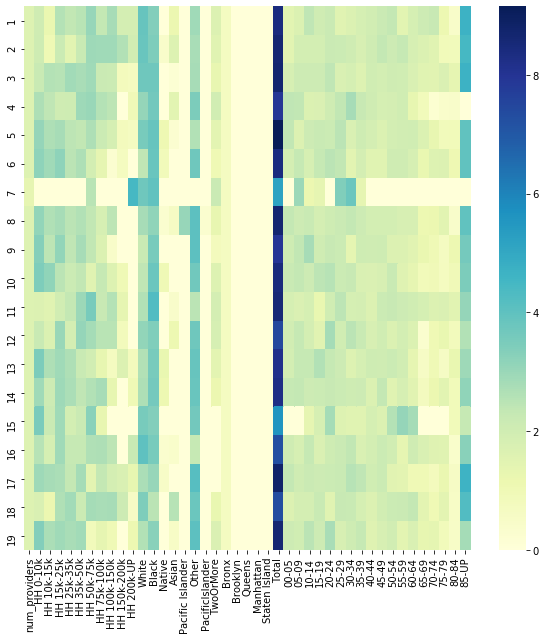

In [23]:
import seaborn as sns
fig, ax = plt.subplots(figsize = (10,10))
sns.heatmap(pd.DataFrame(np.round(pqirba[regressors],2),
            columns = regressors,
            index = range(1,20)),
            cmap="YlGnBu")
plt.show()

our regressors may have correlations with each other, which causes multicollinearity in the following regression.

In [24]:
lm = sm.OLS(pqirba['price'],pqirba[regressors]).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.356
Model:                            OLS   Adj. R-squared:                  0.343
Method:                 Least Squares   F-statistic:                     27.88
Date:                Wed, 27 May 2020   Prob (F-statistic):          5.48e-170
Time:                        13:12:03   Log-Likelihood:                 4207.9
No. Observations:                2165   AIC:                            -8330.
Df Residuals:                    2122   BIC:                            -8086.
Df Model:                          42                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
num_providers       -0.0467      0.007     -6.624      0.000      -0.060      -0.033
HH 0-10k            -0.0007      0.001     -0.488      0.626      -0.004       0.002
HH 10k-15k           0.0013      0.001      0.936      0.349      -0.001       0.004
HH 15k-25k          -0.0017      0.002     -0.983      0.326      -0.005       0.002
HH 25k-35k          -0.0025      0.002     -1.468      0.142      -0.006       0.001
HH 35k-50k          -0.0019      0.002     -1.007      0.314      -0.006       0.002
HH 50k-75k           0.0007      0.002      0.370      0.711      -0.003       0.005
HH 75k-100k          0.0013      0.002      0.698      0.485      -0.002       0.005
HH 100k-150k         0.0047      0.002      2.480      0.013       0.001       0.008
HH 150k-200k         0.0023      0.002      1.414      0.158      -0.001       0.005
HH 200k-UP           0.0050      0.001      3.621      0.000       0.002       0.008
White               -0.0013      0.001     -1.130      0.259      -0.004       0.001
Black                0.0019      0.001      1.999      0.046    3.63e-05       0.004
Native               0.0024      0.002      1.270      0.204      -0.001       0.006
Asian               -0.0017      0.001     -1.933      0.053      -0.003    2.55e-05
Pacific Islander     0.0032      0.002      1.476      0.140      -0.001       0.008
Other                0.0076      0.001      7.204      0.000       0.006       0.010
PacificIslander     -0.0107      0.011     -0.967      0.334      -0.032       0.011
TwoOrMore            0.0064      0.001      4.895      0.000       0.004       0.009
Bronx                6.1750      0.018    350.346      0.000       6.140       6.210
Brooklyn             6.2230      0.019    333.360      0.000       6.186       6.260
Queens               6.2550      0.018    349.223      0.000       6.220       6.290
Manhattan            6.2319      0.020    305.009      0.000       6.192       6.272
Staten Island        6.3005      0.018    356.578      0.000       6.266       6.335
Total               -0.0037      0.002     -2.143      0.032      -0.007      -0.000
00-05                0.0084      0.002      3.957      0.000       0.004       0.013
05-09                0.0038      0.002      1.643      0.100      -0.001       0.008
10-14                0.0025      0.002      1.067      0.286      -0.002       0.007
15-19                0.0030      0.002      1.496      0.135      -0.001       0.007
20-24               -0.0037      0.002     -1.695      0.090      -0.008       0.001
25-29               -0.0017      0.002     -0.710      0.478      -0.007       0.003
30-34               -0.0045      0.002     -1.896      0.058      -0.009       0.000
35-39               -0.0023      0.002     -0.938      0.349      -0.007       0.003
40-44               -0.

*Number of providers: the coefficient is negative, which accords with common knowledge that more providers, less prices.

*The variable income: it seems relatively having less impact on the broadband pricing. People in one certain tract that earn more income may be able to afford more expensive broadband services, which makes the coefficients larger. (Demand side, pushing up prices)

*Age: areas where people range from 30 to 44 live tends to have cheaper broadband services, with P value less than 10%, which may accord with the Bayes Network result - the more 35-49 people the more broadband (Supply side, more services dragging down prices)